<h1>
<center>Classifying Politicians</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd 
import scipy.spatial 
# from numpy.core.function_base import linspace

In [2]:
# if you are using Colab 

from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# STEP 1: Import and preprocess the dataset
path_to_data = '/content/drive/My Drive/Colab Notebooks/house-votes-84.data'

data = pd.read_csv(path_to_data, header=None, delimiter=',') # 435x17 (435 members, 1 col for party, 16 bills)
y = [-1 if party == 'republican' else 1 for party in data[0]] # republican:-1, democrat:+1 # 435x1
X = data.iloc[:,1:].replace('y', 1).replace('n', -1).replace('?', 0) # 435x16


435


sigma* = 1.17, accuracy = 0.8804597701149426


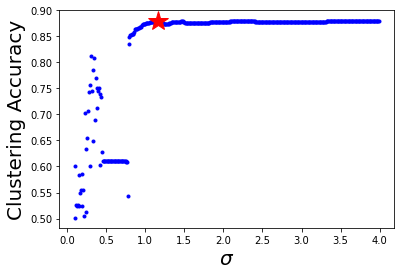

In [8]:
# STEP 2: SPECTRAL CLUSTERING. Use X and y for validation of clustering algorithm. 
# Construct the unnormalized graph Laplacian matrix on X. 
def eta(tt, sigma):
  val = np.exp( - (tt**2)/(2*sigma**2) ) 
  return val.astype(float)

def get_accuracy(sigma):
  dist = scipy.spatial.distance_matrix(X, X, p=2) # could get expensive if a lot of data 

  W = eta(dist, sigma) # weights 

  d = np.sum(W, axis=1) # degree vector
  D = np.diag(d)

  # unnormalized laplacian 
  L = D - W 
  # eigens
  ll, VV = np.linalg.eigh(L)
  # sort the eigenvalues and vectors 
  idx = ll.argsort() 
  l = ll[idx]
  V = VV[:, idx]
  classifier = np.sign(V[:,1]) # sign of 2nd eigenvector, q1

  # Take sign(q) as your classifier and compute its classification 
  # accuracy after comparison with y. 
  accuracy = 1 - (np.sum([classifier != y]) / len(y))
  if accuracy < 0.5: # adjust for opposite classification 
    accuracy = 1 - accuracy

  return accuracy, V

# Change the parameter sigma in the range (0,4] and plot accuracy as a 
# function of sigma. Let sigma* denote the optimal variance parameter 
# achieving maximum clustering accuracy. 
step_size = 0.01
sigmas = np.arange(0.1,4,step=step_size).round(2)
accuracies = []
for sigma in sigmas:
  acc, V = get_accuracy(sigma)
  accuracies.append(acc)

index_max = np.unravel_index(np.argmax(accuracies), len(accuracies))[0]
sigma_star = sigmas[index_max]
accuracy_star = accuracies[index_max]

# plot accuracy 
fig, ax = plt.subplots()
ax.plot(sigmas, accuracies, 'bo', markersize=3)
ax.plot(sigma_star, accuracy_star, 'r*', markersize=20)
ax.set_xlabel('$\sigma$', fontsize=20)
ax.set_ylabel('Clustering Accuracy', fontsize=20)
plt.ylim(top=0.9)

print('sigma* = ' + str(sigma_star) + ', accuracy = ' + str(accuracy_star))


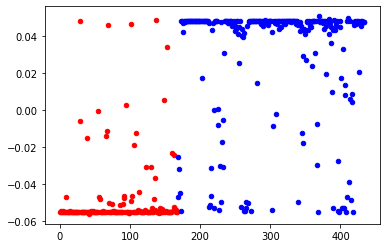

In [5]:
# Plot q1
acc_star, q1_star = get_accuracy(sigma_star)
republicans_idx = [i for i,val in enumerate(y) if val == -1]
democrats_idx = [i for i,val in enumerate(y) if val == 1]
rep_len = len(republicans_idx)
dem_len = len(democrats_idx)
fig, ax = plt.subplots()
plt.scatter(np.arange(rep_len), q1_star[republicans_idx,1], c='r', s=20)
plt.scatter(np.arange(rep_len,rep_len+dem_len), q1_star[democrats_idx,1], c='b', s=20)
plt.legend(['Republicans', 'Democrats'])


In [10]:
# STEP 3: SEMI-SUPERVISED LEARNING.  
def get_SSLLinear_accuracy(M, J, sigma_star):
  dist = scipy.spatial.distance_matrix(X, X, p=2) # could get expensive if a lot of data 

  W = eta(dist, sigma_star) # weights 

  d = np.sum(W, axis=1) # degree vector
  D = np.diag(d)
  Ds = np.diag(1/np.sqrt(d))
  Di = np.diag(1/d)

  # unnormalized laplacian 
  L = D - W 
  # eigens
  ll, VV = np.linalg.eigh(L)
  # sort the eigenvalues and vectors 
  idx = ll.argsort() 
  l = ll[idx]
  V = VV[:, idx]

  # Given an integer M >= 1 consider the Laplacian embedding 
  # where q_j denote the eigenvectors of the laplacian matrix. 
  F = V[:, 0:M] 

  # Given an integer J >= 1 consider the submatrix A and vector b 
  # consisting of the first J rows of F(X) and y.
  A = F[0:J, 0:M] # first J rows, first M cols (top left block)
  b = y[0:J] 

  # Use linear regression (least squares) to find beta_hat then 
  # take y_hat=sign(F(X)beta_hat) as predictor of classes of all points in X.
  SSLLinear = LinearRegression(fit_intercept=False) 
  SSLLinear.fit(A, b)
  beta_hat = SSLLinear.coef_ # coefs of linear regression 
  Fbeta_hat = np.dot(F, beta_hat)
  y_hat =  np.sign(Fbeta_hat)
  SSL_accuracy = 1 - (np.sum([y != y_hat]) / len(y))

  return SSL_accuracy, beta_hat

# Provide a table summarizing the accuracy of y_hat as your classifier for M=2,3,4,5,6 and J=5,10,20,40
Ms = [2, 3, 4, 5, 6] # number of eigenvectors to use as feature maps in regression 
Js = [5, 10, 20, 40] # number of rows 
MJ = np.array([[0.0]*len(Js)]*len(Ms))
for m, M in enumerate(Ms):
  for j, J in enumerate(Js): 
    acc, beta = get_SSLLinear_accuracy(M, J, 1.16)
    MJ[m,j] = acc

MJ = pd.DataFrame(MJ)
MJ.index = Ms
MJ.columns = Js
print(MJ)


         5         10        20        40
2  0.889655  0.887356  0.882759  0.880460
3  0.887356  0.816092  0.820690  0.836782
4  0.839080  0.850575  0.864368  0.875862
5  0.868966  0.710345  0.839080  0.880460
6  0.868966  0.685057  0.873563  0.864368
